# <center>Classical Mathematical Models for Prediction of Response to Therapy 

---
## <center> Defined Needed Libraries 

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import interpolate
import warnings    

---
## <center> Generates the Treatment and Defined the Parameters

Define treatments matrix where each array represents a distinct treatment and each value in the array represents dose amount treatment is given on seven sessions every two days a dose is given, we take observations every two hours each observation contains: Cancer type 1, Type 2 and immune Cells population.

In [3]:
Treatment = [[0, 0, 0, 0, 0, 0, 0],
             [10**-9, 10**-9, 10**-9, 10**-9, 10**-9, 10**-9, 10**-9], 
             [10**-5, 10**-5, 10**-5, 10**-5, 10**-5, 10**-5, 10**-5],
             [10**-9, 10**-5, 10**-9, 10**-5, 10**-9, 10**-5, 10**-9]]
# we take observations every two hours each observation contains: Cancer type 1, Type 2 and immune Cells population
observations_horizon = 24  # n number of observations for each value of single treatment
treatment_full = [[c[T] for T in range(len(c)) for k in range(observations_horizon)] for c in Treatment] 

x0 = np.array([60.4551985, 56.1345208, 46.32307756]) # initial conditions
r1, r2, r3 = 0.03, 0.07, 0.06 # growth rates
c1, c2, c3 = 0.04, 0.05, 0.05 # death rates
k1, k2, k3 = 100, 200, 200 # carrying capacities
b11, b12, b13 = 0.01, 0.02, 0.005 # interaction between cancer cells
b21, b22, b23 = 0, 0.01, 0.05 # interaction between cancer cells
b31, b32, b33 = 0, 0.02, 0.01 # interaction between cancer cells
a = 2/3 # positive parameter
t = np.linspace(1, len(treatment_full[0]), num= len(treatment_full[0])) * 2 # time (hour)
num_plots = len(treatment_full) # Set the number of plots to be generated
num_cols = 2  # Set the number of columns for subplots (can be adjusted as needed)
num_rows = int(np.ceil(num_plots / num_cols))
warnings.filterwarnings('ignore')


---
## <center> Classical Lotka-Volterra Model
The classical lotka volterra model is geven by:
$\dot{N}_i=N_i(r_i-(c_i + c_iq(t))\left(1 - \cfrac{N_i + \sum_{j\neq i} a_{ij}N_j}{K_i}\right)$ 
where:
* $N_i$: population $i$ density
* $r_i$: growth rate
* $q(t)$: amoutnt of treatment at time t 
* $c_i$: treatment parameters
* $K_i$: carrying capacity 
* $a_{ij}$: the effect of individual of type $i$ on individual of type $j$

In [4]:
def lotka_volterra(x0, treatment, params, show_plot:bool = True ):
    """
    Classical Lotka-Volterra Model
    x0: initial population size
    treatment: list of treatment
    params: parameters of the model
    show_plot: whether to show the plot
    return: population size of each population
    """
    r1, r2, r3, b12, b13, b21, b23, b31, b32, c1, c2, c3, k1, k2, k3 = params # Parameters of the model
    i1p, x1p, x2p = [], [], []
    for i in treatment: 
        i_curr, x1_curr, x2_curr = x0   
        i11p, x11p, x22p = [], [], []
        for k in range(len(i)):
            di11 = i_curr * (1 - (i_curr + b12 * x1_curr + b13 * x2_curr)/k1) * (r1 - (c1 + c1 * 10**5 * i[k]))
            dx11 = x1_curr * (1 - (x1_curr + b21 * i_curr + b23 * x2_curr)/k2) * (r2 - (c2 + c2 * 10**5 * i[k]))
            dx22 = x2_curr * (1 - (x2_curr + b31 * i_curr + b32 * x1_curr)/k3) * (r3 - (c3 + c3 * 10**5 * i[k]))
            i11p.append(i_curr), x11p.append(x1_curr), x22p.append(x2_curr)
            i_curr += di11
            x1_curr += dx11
            x2_curr += dx22
        i1p.append(i11p), x1p.append(x11p), x2p.append(x22p)
    if show_plot:
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(9.5 * num_cols, 8))
        for j in range(num_plots):
            row = j // num_cols
            col = j % num_cols
            ax = axes[row, col] 
            for k, label in zip([i1p, x1p, x2p], ['immune cells i', 'U87 cells x1', 'U251 cells x2']):
                ax.plot(t, k[j], '-', label=label)
            ax.plot(t, np.array(x1p[j]) + np.array(x2p[j]), ':', label=f'caner size')
            ax.set_xlabel('Time')
            ax.set_ylabel('Population Size')
            ax.set_title(f'Populations sizes with treatment {Treatment[j]}')
            ax.legend()
            plt.tight_layout() 
        fig.suptitle("Population Sizes with Different Treatments Using Classical Lotka-Volterra Model", fontsize=24, y=1.06)
        plt.show() 
    return i1p, x1p, x2p

### Example: Generate specific data to fit our model to

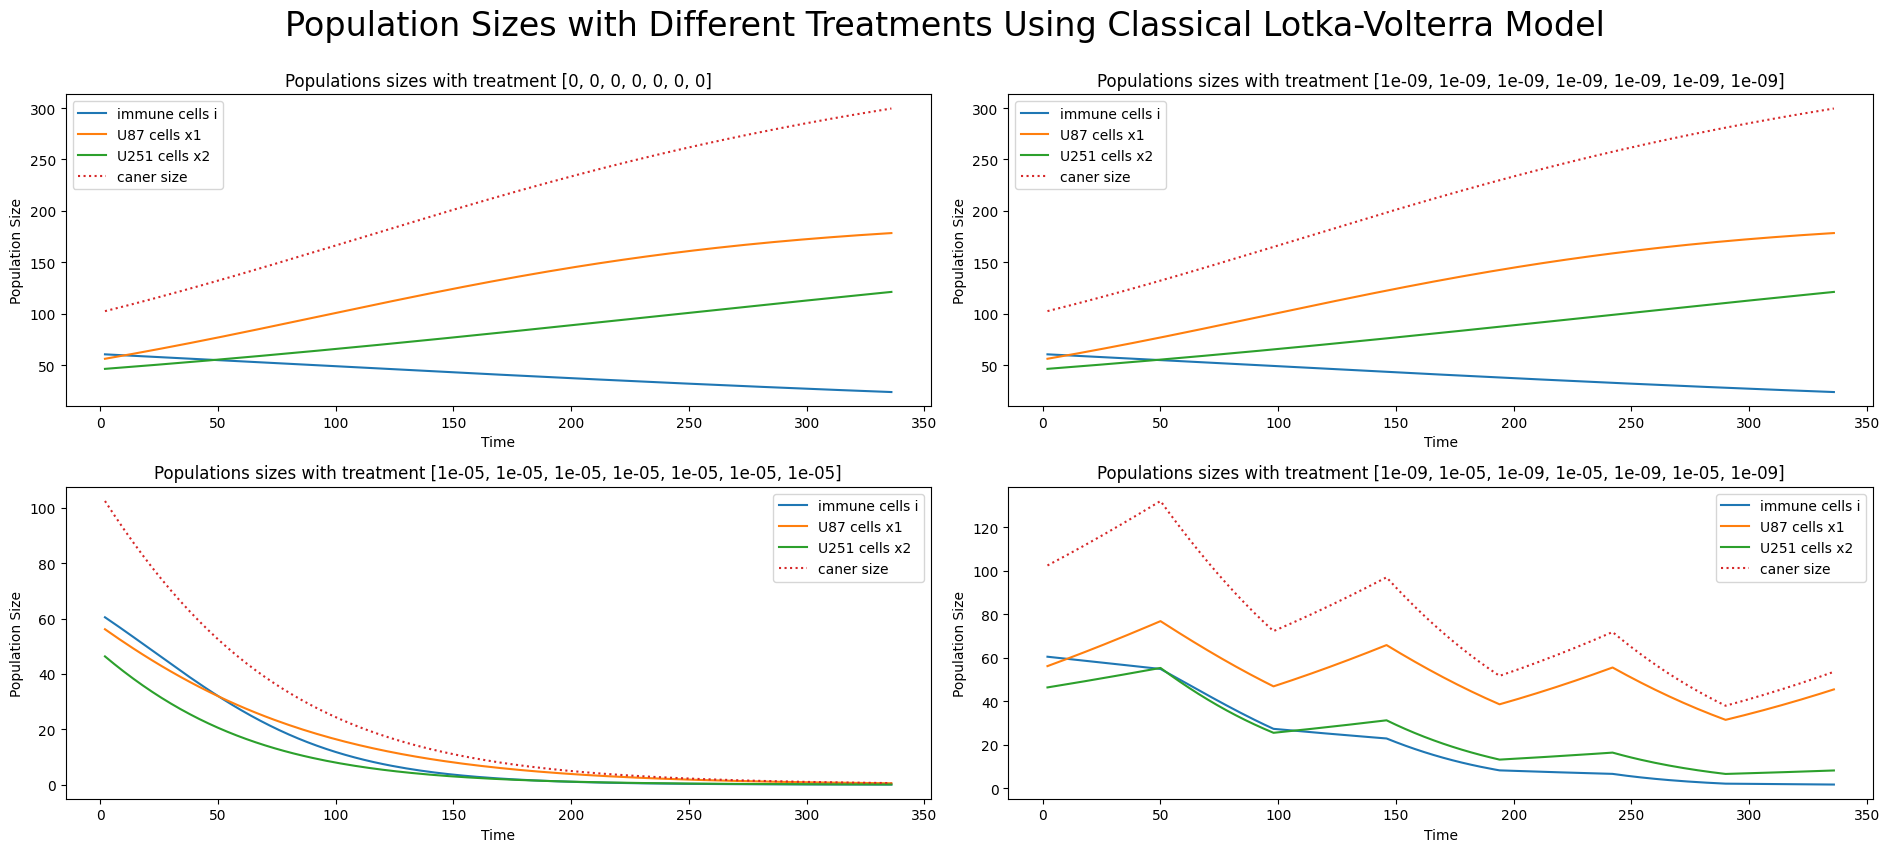

In [5]:
param = [r1, r2, r3, b12, b13, b21, b23, b31, b32, c1, c2, c3, k1, k2, k3]
i, x1, x2 = np.array(lotka_volterra(x0,treatment_full, param, show_plot=True))

### Plot the Change of Rate of i, x1, x2 (didt, dx1dt, dx2dt).

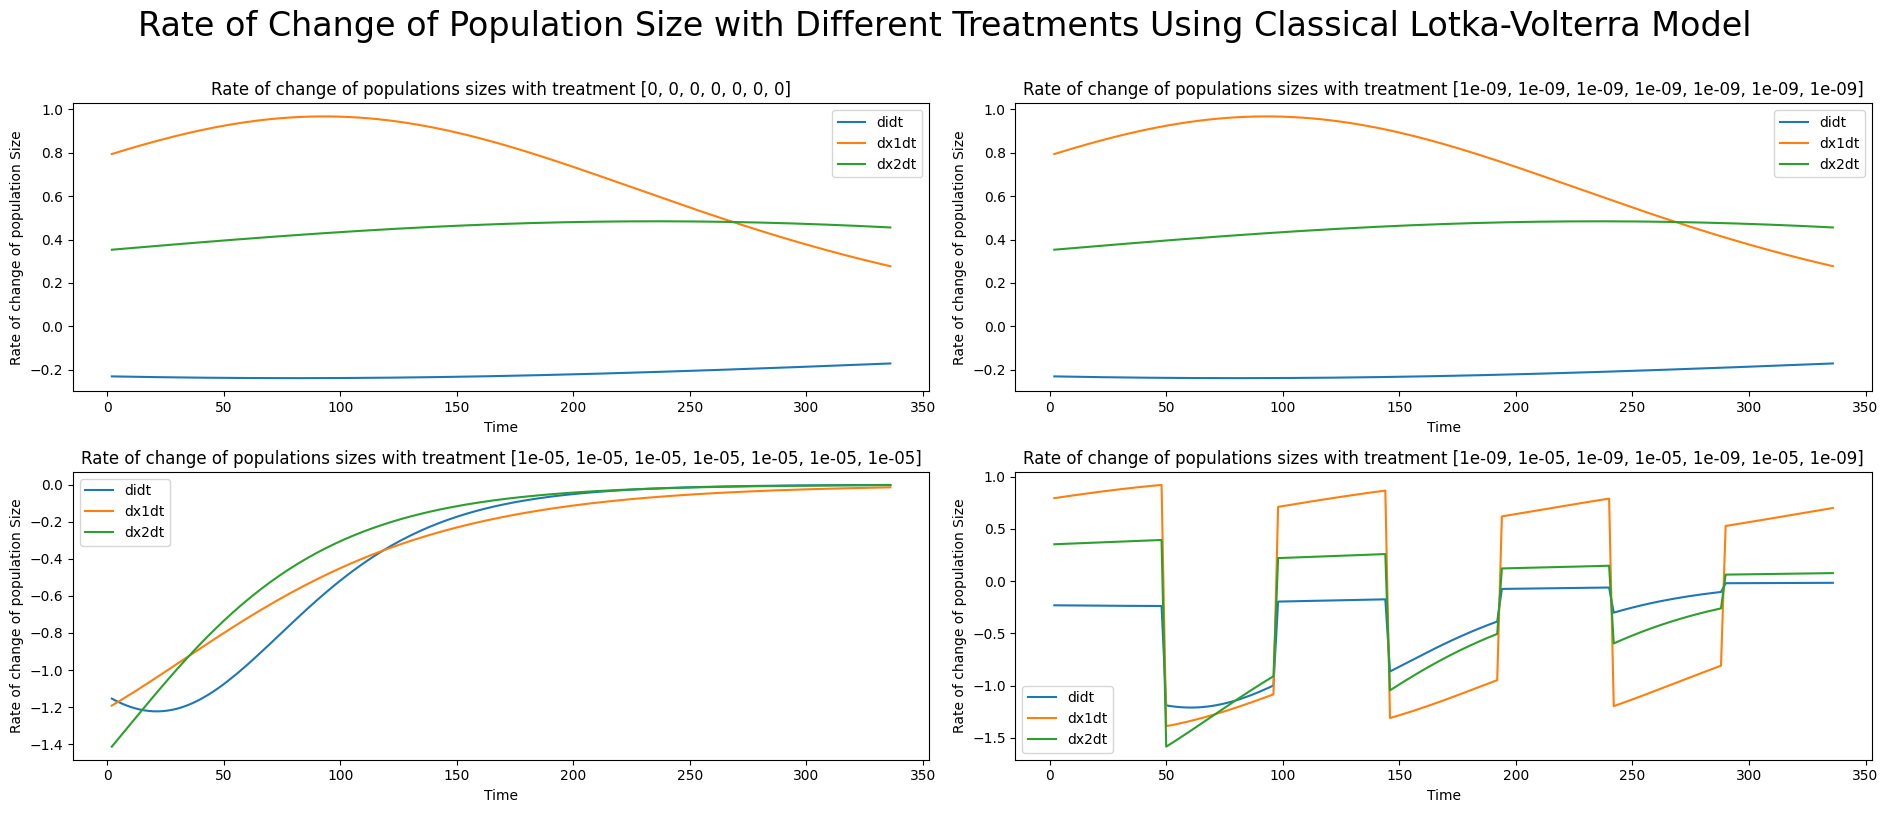

In [66]:
def ODEs(V, t, treatment_interpolator, r1, r2, r3, b12, b13, b21, b23, b31, b32, c1, c2, c3, k1, k2, k3):
    '''  
    function that returns the rate of change of the populations sizes of the three species
    V: list of the initial population sizes of the three species
    t: time
    treatment_interpolator: function that returns the treatment at time t
    r1, r2, r3: intrinsic growth rates of the three species
    b12, b13, b21, b23, b31, b32: interaction coefficients between the three species
    c1, c2, c3: death rates of the three species
    k1, k2, k3: carrying capacities of the three species
    returns: list of the rate of change of the populations sizes of the three species
    '''
    i, x1, x2 = V  
    current_treatment = treatment_interpolator(t) 
    didt = i * (r1 - c1 - c1 * 10**5 * current_treatment) * (1 - (i + b12 * x1 + b13 * x2)/k1)
    dx1dt = x1 * (r2 - c2 - c2 * 10**5 * current_treatment) * (1 - (x1 + b21 * i + b23 * x2)/k2)
    dx2dt = x2 * (r3 - c3 - c3 * 10**5 * current_treatment) * (1 - (x2 + b31 *i +b32 * x1)/k3)
    return [didt, dx1dt, dx2dt]

fig, axes = plt.subplots(num_rows, num_cols, figsize=(9.5 * num_cols, 8))
for I in range(len(Treatment)):
    V = [i[I], x1[I], x2[I]]
    treatment_interpolator = interpolate.interp1d(t, treatment_full[I], fill_value="extrapolate")
    didt, dx1dt, dx2dt = ODEs(V, t, treatment_interpolator, r1, r2, r3, b12, b13, b21, b23, b31, b32, c1, c2, c3, k1, k2, k3)
    row = I // num_cols
    col = I % num_cols    
    ax = axes[row, col]  
    for k, label in zip([didt, dx1dt, dx2dt], ['didt', 'dx1dt', 'dx2dt']):
        ax.plot(t, k, '-', label=label)
    ax.set_title(f'Rate of change of populations sizes with treatment {Treatment[I]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Rate of change of population Size')
    ax.legend()
fig.suptitle("Rate of Change of Population Size with Different Treatments Using Classical Lotka-Volterra Model", fontsize=24, y=1.01)
plt.tight_layout() 
plt.show()

---
## <center> Exponential Model
The exponential model is geven by:
$\dot{N}_i=N_i(r_i-c_i q(t))$ 
where:
* $N_i$: population $i$ density 
* $r_i$: growth rate
* $q(t)$: amoutnt of treatment at time t 
* $c_i$: treatment parameters

In [67]:
def exponential(x0, treatment, params, show_plot:bool = True ):
    """This function is used to simulate the exponential model for the cancer growth
    x0: initial population size of the immune cells, U87 cells and U251 cells
    treatment: a list of treatment, each treatment is a list of the concentration of the drug
    params: a list of parameters for the model
    show_plot: a boolean variable to determine whether to show the plot of the simulation
    return: a list of the population size of the immune cells, U87 cells and U251 cells for each treatment
    """
    r1, r2, r3, c1, c2, c3 = params
    i1p, x1p, x2p = [], [], []
    for i in treatment:  
        i_curr, x1_curr, x2_curr = x0 
        i11p, x11p, x22p = [], [], []
        for k in range(len(i)):
            di11 = i_curr * (r1 - c1 - c1 * 10**5 * i[k])
            dx11 = x1_curr * (r2 - c2 - c2 * 10**5 * i[k])
            dx22 = x2_curr * (r3 - c3 - c3 * 10**5 * i[k])
            i11p.append(i_curr), x11p.append(x1_curr), x22p.append(x2_curr)
            i_curr += di11
            x1_curr += dx11
            x2_curr += dx22
        i1p.append(i11p), x1p.append(x11p), x2p.append(x22p) 
    if show_plot:
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(9.5 * num_cols, 8))
        for j in range(num_plots):
            row = j // num_cols
            col = j % num_cols
            ax = axes[row, col] 
            for k, label in zip([i1p, x1p, x2p], ['immune cells i', 'U87 cells x1', 'U251 cells x2']):
                ax.plot(t, k[j], '-', label=label)
            ax.plot(t, np.array(x1p[j]) + np.array(x2p[j]), ':', label=f'caner size')
            ax.set_xlabel('Time')
            ax.set_ylabel('Population Size')
            ax.set_title(f'Populations sizes with treatment {Treatment[j]}')
            ax.legend() 
            plt.tight_layout() 
        fig.suptitle("Population Sizes with Different Treatments Using Exponential Model", fontsize=24, y=1.06)
        plt.show() 
    return i1p, x1p, x2p

### Example: Generate specific data to fit our model to

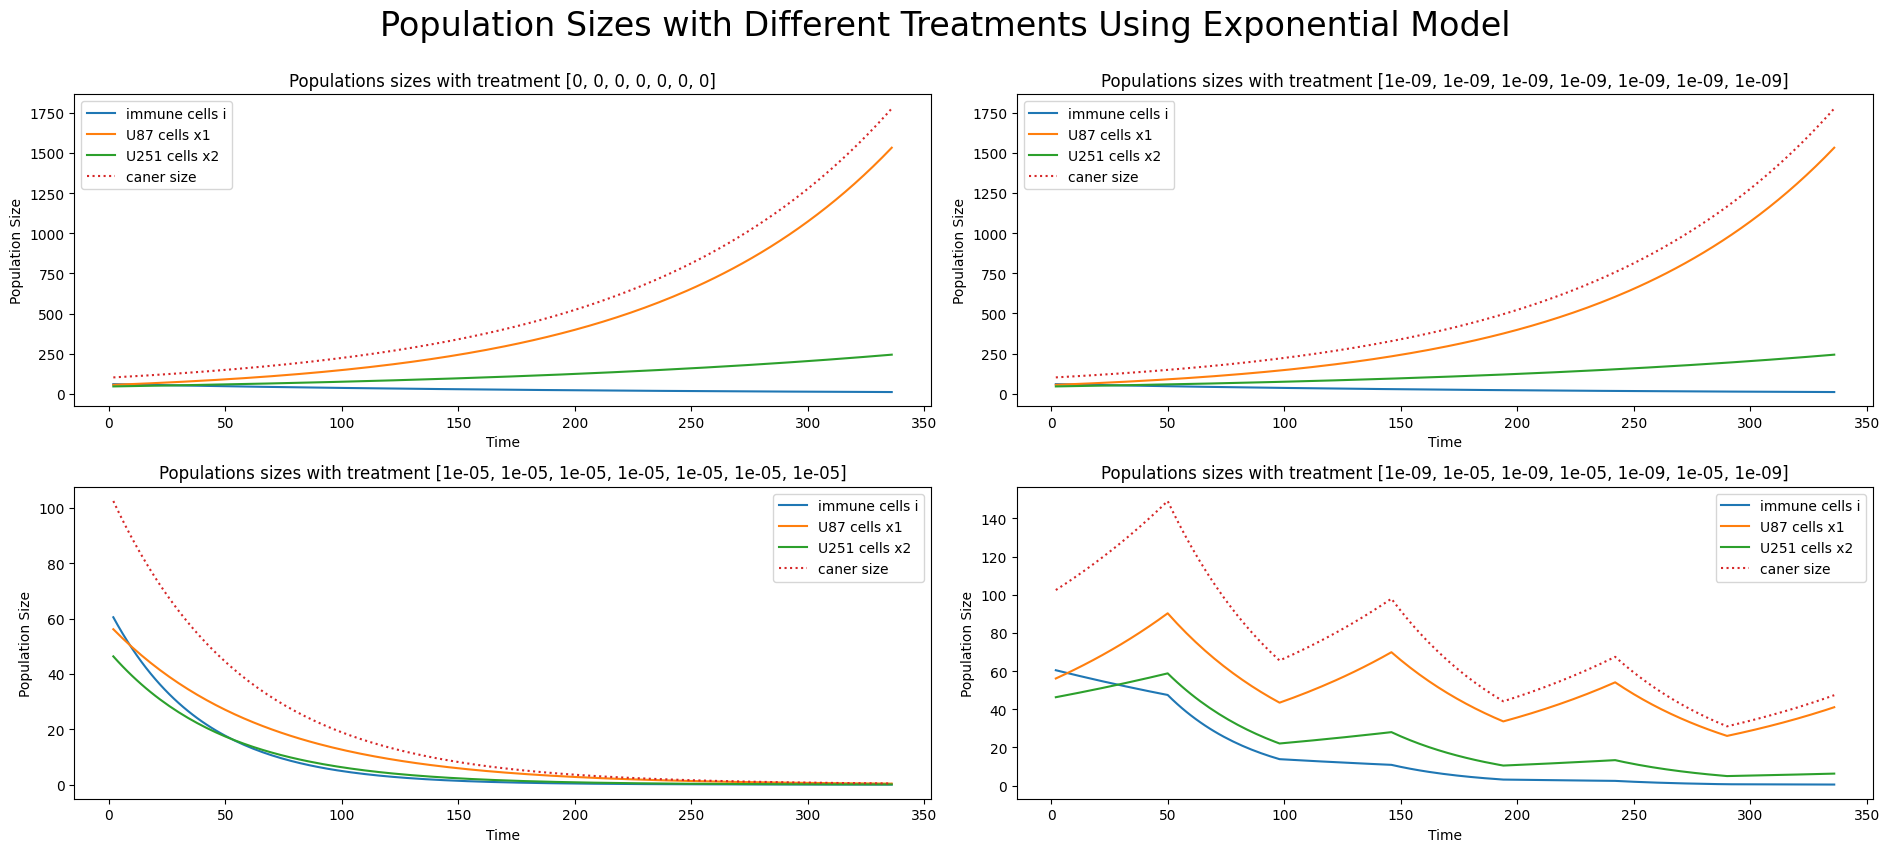

In [68]:
param = [r1, r2, r3, c1, c2, c3]
i, x1, x2 = np.array(exponential(x0,treatment_full, param, show_plot=True))

### Plot the Change of Rate of i, x1, x2 (didt, dx1dt, dx2dt).

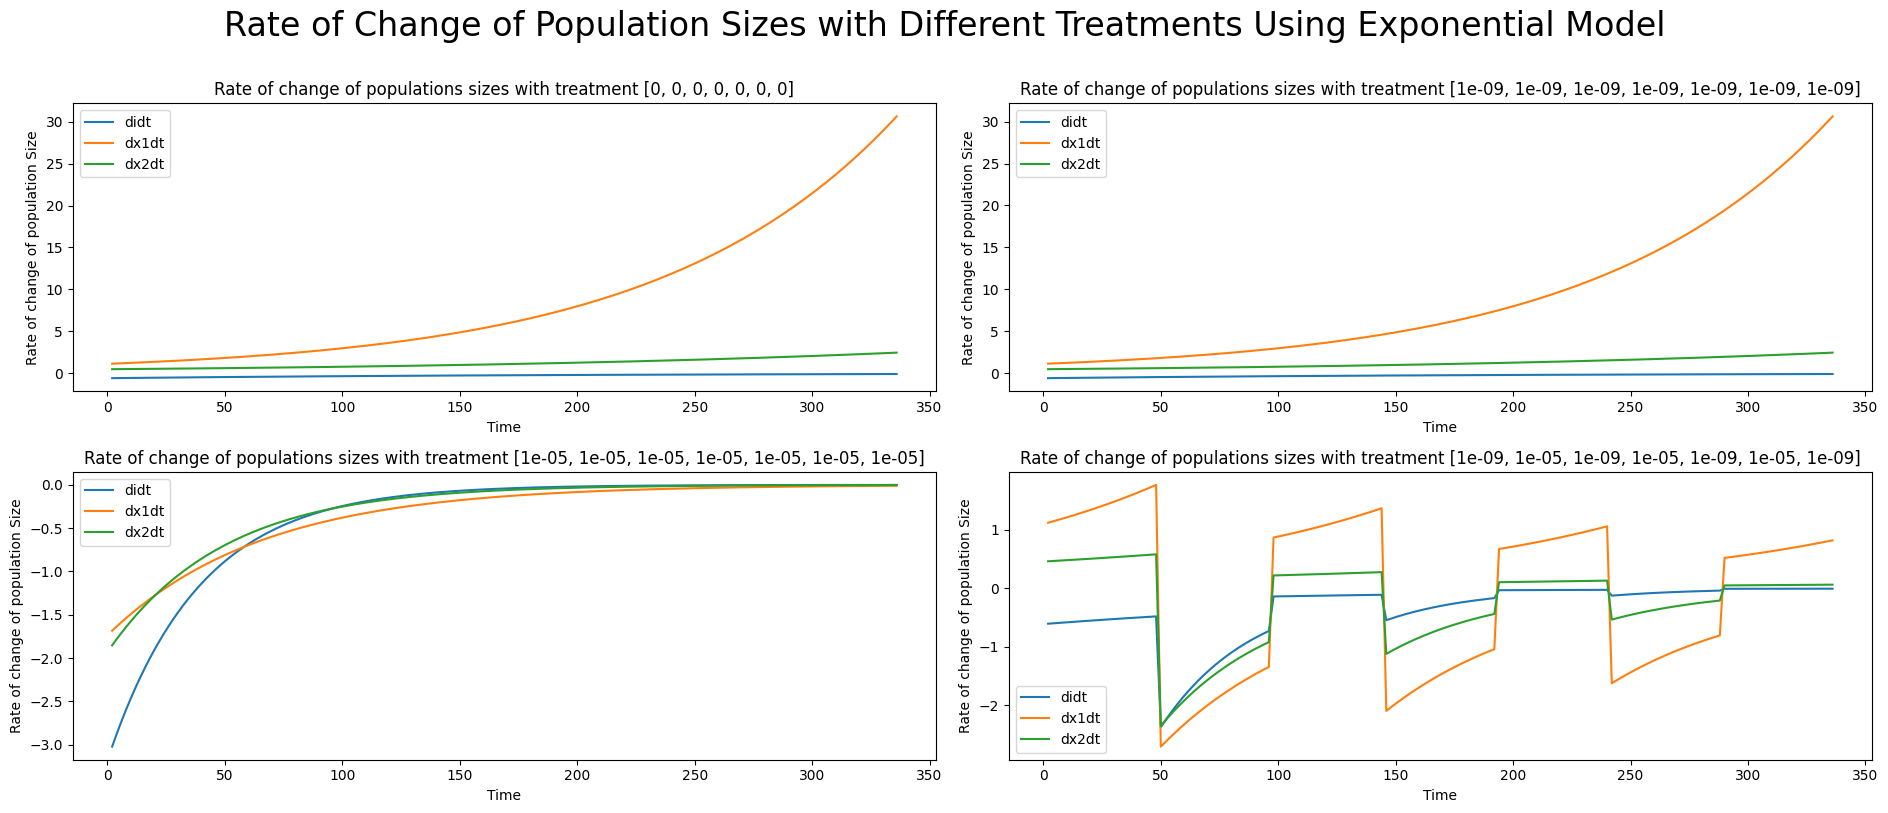

In [69]:
def ODEs(V, t, treatment_interpolator, r1, r2, r3, c1, c2, c3):
    ''' 
    ODEs for the exponential model
    V: list of initial values
    t: time
    treatment_interpolator: function that interpolates treatment
    r1, r2, r3, c1, c2, c3: parameters
    returns: list of ODEs    
    '''
    i, x1, x2 = V  
    current_treatment = treatment_interpolator(t) 
    didt = i * (r1 - c1 - c1 * 10**5 * current_treatment) 
    dx1dt = x1 * (r2 - c2 - c2 * 10**5 * current_treatment) 
    dx2dt = x2 * (r3 - c3 - c3 * 10**5 * current_treatment)
    return [didt, dx1dt, dx2dt]
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9.5 * num_cols, 8))
for I in range(len(Treatment)):
    V = [i[I], x1[I], x2[I]]
    treatment_interpolator = interpolate.interp1d(t, treatment_full[I], fill_value="extrapolate")
    didt, dx1dt, dx2dt = ODEs(V, t, treatment_interpolator, r1, r2, r3, c1, c2, c3)
    row = I // num_cols
    col = I % num_cols    
    ax = axes[row, col]  
    for k, label in zip([didt, dx1dt, dx2dt], ['didt', 'dx1dt', 'dx2dt']):
        ax.plot(t, k, '-', label=label)
    ax.set_title(f'Rate of change of populations sizes with treatment {Treatment[I]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Rate of change of population Size')
    ax.legend()
fig.suptitle("Rate of Change of Population Sizes with Different Treatments Using Exponential Model", fontsize=24, y=1.01)
plt.tight_layout()
plt.show()

---
## <center> Logistc Model
The logistic model is geven by: $\dot{N}_i= N_i(r_i-(c_i+c_iq(t))\left(1-\cfrac{N_i}{K_i}\right)$
where:
* $N_i$: population $i$ density
* $r_i$: growth rate
* $q(t)$: amoutnt of treatment at time t 
* $c_i$: treatment parameters
* $K_i$: carrying capacity 

In [70]:
def logistic(x0, treatment, params, show_plot:bool = True ):
    """This function is used to simulate the logistic model for the cancer treatment
    x0: initial population size of immune cells, U87 cells, U251 cells
    treatment: the treatment for the cancer
    params: the parameters for the model
    show_plot: whether to show the plot of the simulation
    return: the population size of immune cells, U87 cells, U251 cells
    """
    r1, r2, r3, c1, c2, c3, k1, k2, k3 = params # Parameters of the model
    i1p, x1p, x2p = [], [], []
    for i in treatment: 
        i_curr, x1_curr, x2_curr = x0   
        i11p, x11p, x22p = [], [], []
        for k in range(len(i)):
            di11 = i_curr * (1 - i_curr / k1) * (r1 - (c1 + c1 * 10**5 * i[k]))
            dx11 = x1_curr * (1 - x1_curr / k2) * (r2 - (c2 + c2 * 10**5 * i[k]))
            dx22 = x2_curr * (1 - x2_curr / k3) * (r3 - (c3 + c3 * 10**5 * i[k]))
            i11p.append(i_curr), x11p.append(x1_curr), x22p.append(x2_curr)
            i_curr += di11
            x1_curr += dx11
            x2_curr += dx22
        i1p.append(i11p), x1p.append(x11p), x2p.append(x22p)
    if show_plot:
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(9.5 * num_cols, 8))
        for j in range(num_plots):
            row = j // num_cols
            col = j % num_cols
            ax = axes[row, col] 
            for k, label in zip([i1p, x1p, x2p], ['immune cells i', 'U87 cells x1', 'U251 cells x2']):
                ax.plot(t, k[j], '-', label=label)
            ax.plot(t, np.array(x1p[j]) + np.array(x2p[j]), ':', label=f'caner size')
            ax.set_xlabel('Time')
            ax.set_ylabel('Population Size')
            ax.set_title(f'Populations sizes with treatment {Treatment[j]}')
            ax.legend()
            plt.tight_layout() 
        fig.suptitle("Population Sizes with Different Treatments Using Logistic Model", fontsize=24, y=1.06)
        plt.show() 
    return i1p, x1p, x2p

### Example: Generate specific data to fit our model to

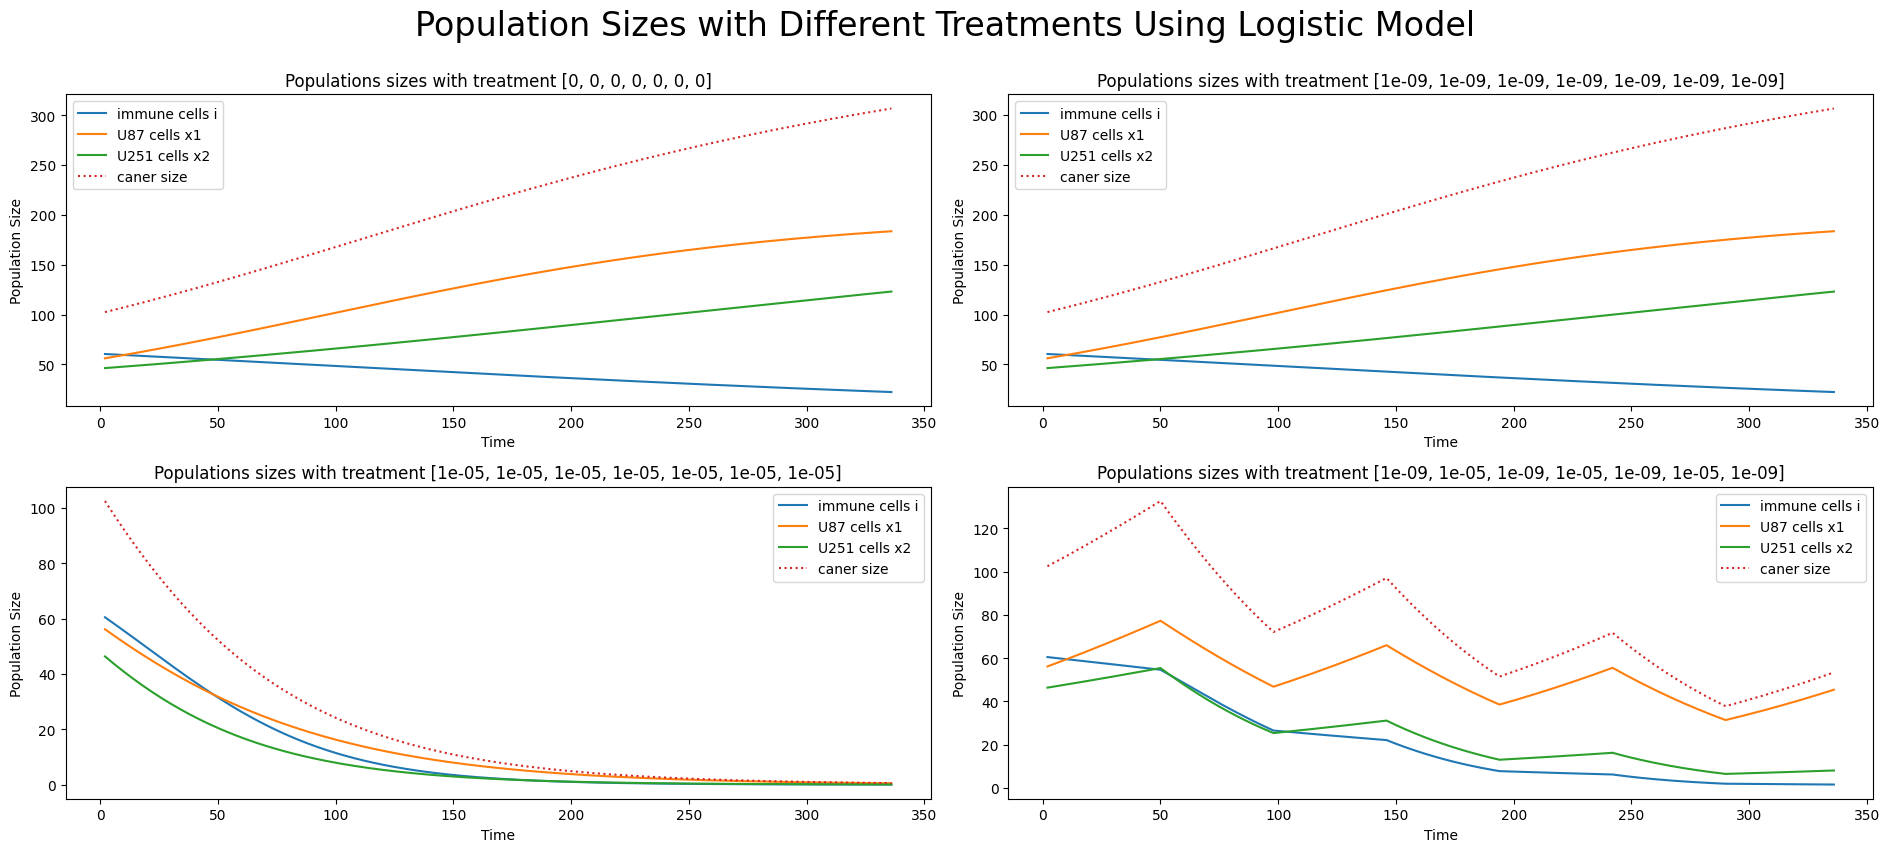

In [71]:
param = [r1, r2, r3, c1, c2, c3, k1, k2, k3]
i, x1, x2 = np.array(logistic(x0,treatment_full, param, show_plot=True))

### Plot the Change of Rate of i, x1, x2 (didt, dx1dt, dx2dt).

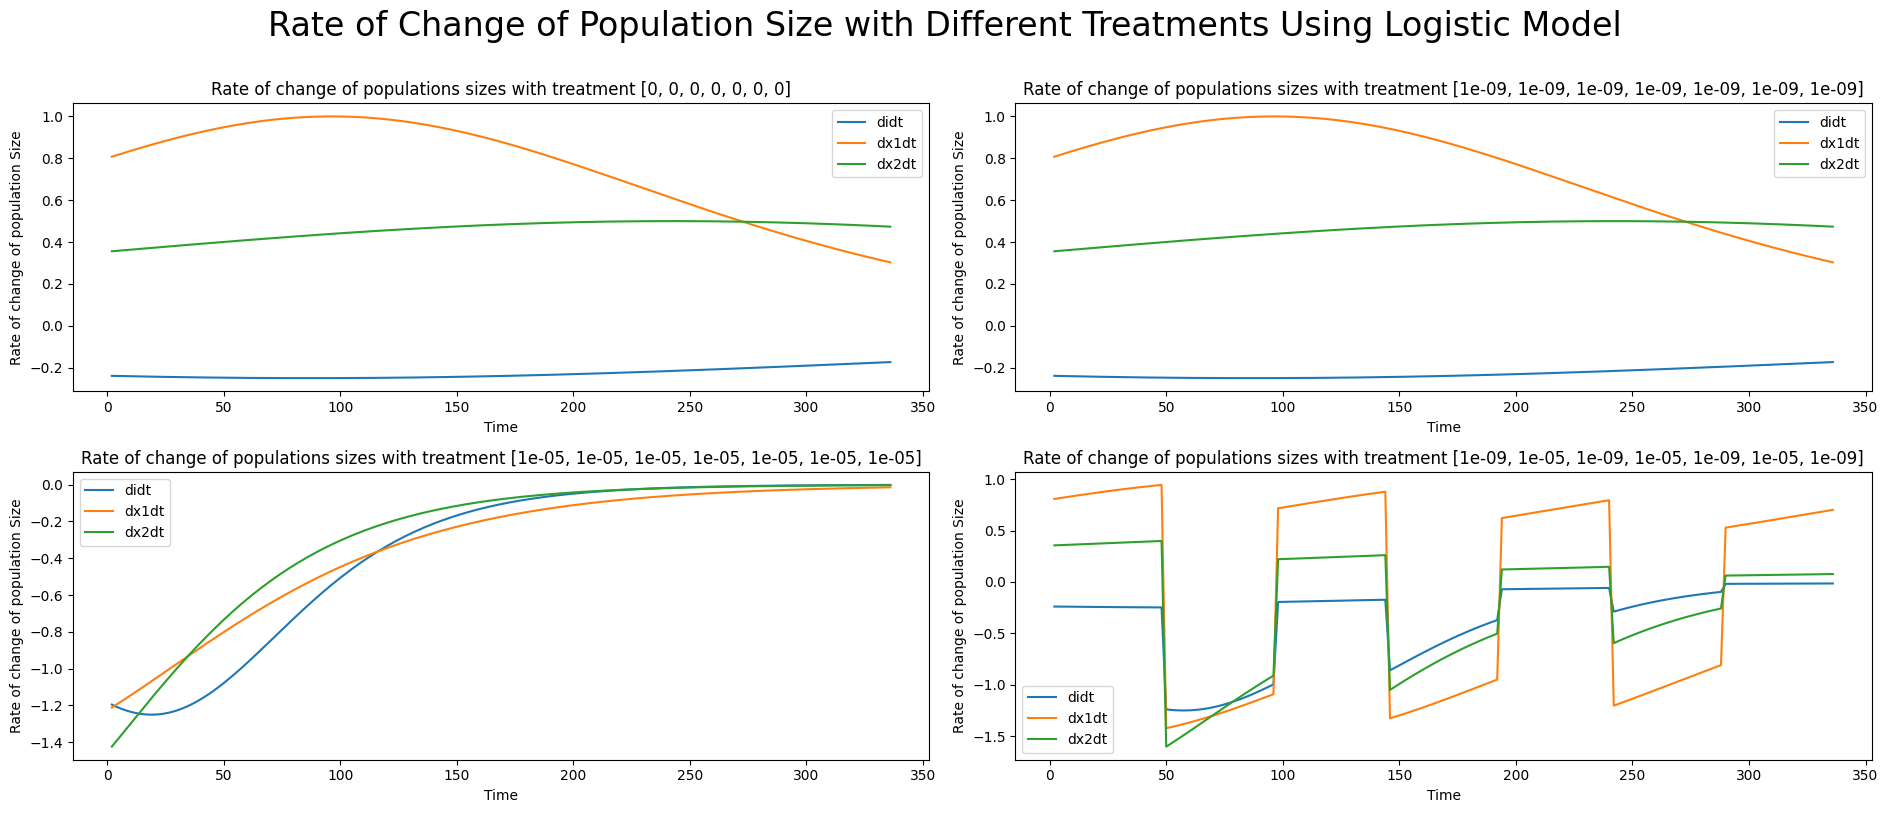

In [72]:
def ODEs(V, t, treatment_interpolator, r1, r2, r3, c1, c2, c3, k1, k2, k3):
    '''  
    function that returns the rate of change of the populations sizes of the three species
    V: list of the initial population sizes of the three species
    t: time
    treatment_interpolator: function that returns the treatment at time t
    r1, r2, r3: intrinsic growth rates of the three species
    b12, b13, b21, b23, b31, b32: interaction coefficients between the three species
    c1, c2, c3: death rates of the three species
    k1, k2, k3: carrying capacities of the three species
    returns: list of the rate of change of the populations sizes of the three species
    '''
    i, x1, x2 = V  
    current_treatment = treatment_interpolator(t) 
    didt = i * (r1 - c1 - c1 * 10**5 * current_treatment) * (1 - i / k1)
    dx1dt = x1 * (r2 - c2 - c2 * 10**5 * current_treatment) * (1 - x1 / k2)
    dx2dt = x2 * (r3 - c3 - c3 * 10**5 * current_treatment) * (1 - x2 / k3)
    return [didt, dx1dt, dx2dt]

fig, axes = plt.subplots(num_rows, num_cols, figsize=(9.5 * num_cols, 8))
for I in range(len(Treatment)):
    V = [i[I], x1[I], x2[I]]
    treatment_interpolator = interpolate.interp1d(t, treatment_full[I], fill_value="extrapolate")
    didt, dx1dt, dx2dt = ODEs(V, t, treatment_interpolator, r1, r2, r3, c1, c2, c3, k1, k2, k3)
    row = I // num_cols
    col = I % num_cols    
    ax = axes[row, col]  
    for k, label in zip([didt, dx1dt, dx2dt], ['didt', 'dx1dt', 'dx2dt']):
        ax.plot(t, k, '-', label=label)
    ax.set_title(f'Rate of change of populations sizes with treatment {Treatment[I]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Rate of change of population Size')
    ax.legend()
fig.suptitle("Rate of Change of Population Size with Different Treatments Using Logistic Model", fontsize=24, y=1.01)
plt.tight_layout() 
plt.show()

---
## <center> Gompertz Model
The gompertz model is geven by:
$\dot{N}_i=N_i(r_i-c_i q(t))ln(\frac{K_i}{N_i})$ 
where:
* $N_i$: population density
* $r_i$: growth rate
* $q(t)$: amoutnt of treatment at time t 
* $c_i$: treatment parameters
* $K_i$: carring capacity

In [73]:
def gompertz(x0, treatment, params, show_plot:bool = True ):
    """
    This function is used to simulate the Gompertz model for the given parameters and initial conditions.
    x0: initial conditions for the model
    treatment: list of treatments
    params: parameters of the model
    show_plot: boolean value to show the plot or not
    return: the population sizes of each population for each treatment
    """
    r1, r2, r3, c1, c2, c3, k1, k2, k3 = params 
    i1p, x1p, x2p = [], [], []
    for i in treatment:  
        i_curr, x1_curr, x2_curr = x0  
        i11p, x11p, x22p = [], [], []
        for k in range(len(i)):
            di11 = i_curr * (r1 - c1 - c1 * 10**5 * i[k]) * (np.log(k1/i_curr))
            dx11 = x1_curr * (r2 - c2 - c2 * 10**5 * i[k]) * (np.log(k2/x1_curr))
            dx22 = x2_curr * (r3 - c3 - c3 * 10**5 * i[k]) * (np.log(k3/x2_curr))
            i11p.append(i_curr), x11p.append(x1_curr), x22p.append(x2_curr)
            i_curr += di11
            x1_curr += dx11
            x2_curr += dx22
        i1p.append(i11p), x1p.append(x11p), x2p.append(x22p) 
    if show_plot:
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(9.5 * num_cols, 8))
        for j in range(num_plots):
            row = j // num_cols
            col = j % num_cols
            ax = axes[row, col]  
            for k, label in zip([i1p, x1p, x2p], ['immune cells i', 'U87 cells x1', 'U251 cells x2']):
                ax.plot(t, k[j], '-', label=label)
            ax.plot(t, np.array(x1p[j]) + np.array(x2p[j]), ':', label=f'caner size')
            ax.set_xlabel('Time')
            ax.set_ylabel('Population Size')
            ax.set_title(f'Populations sizes with treatment {Treatment[j]}')
            ax.legend() 
            plt.tight_layout() 
        fig.suptitle("Population Sizes with Different Treatments Using Gompertz Model", fontsize=24, y=1.06)
        plt.show() 
    return i1p, x1p, x2p

### Example: Generate specific data to fit our model to

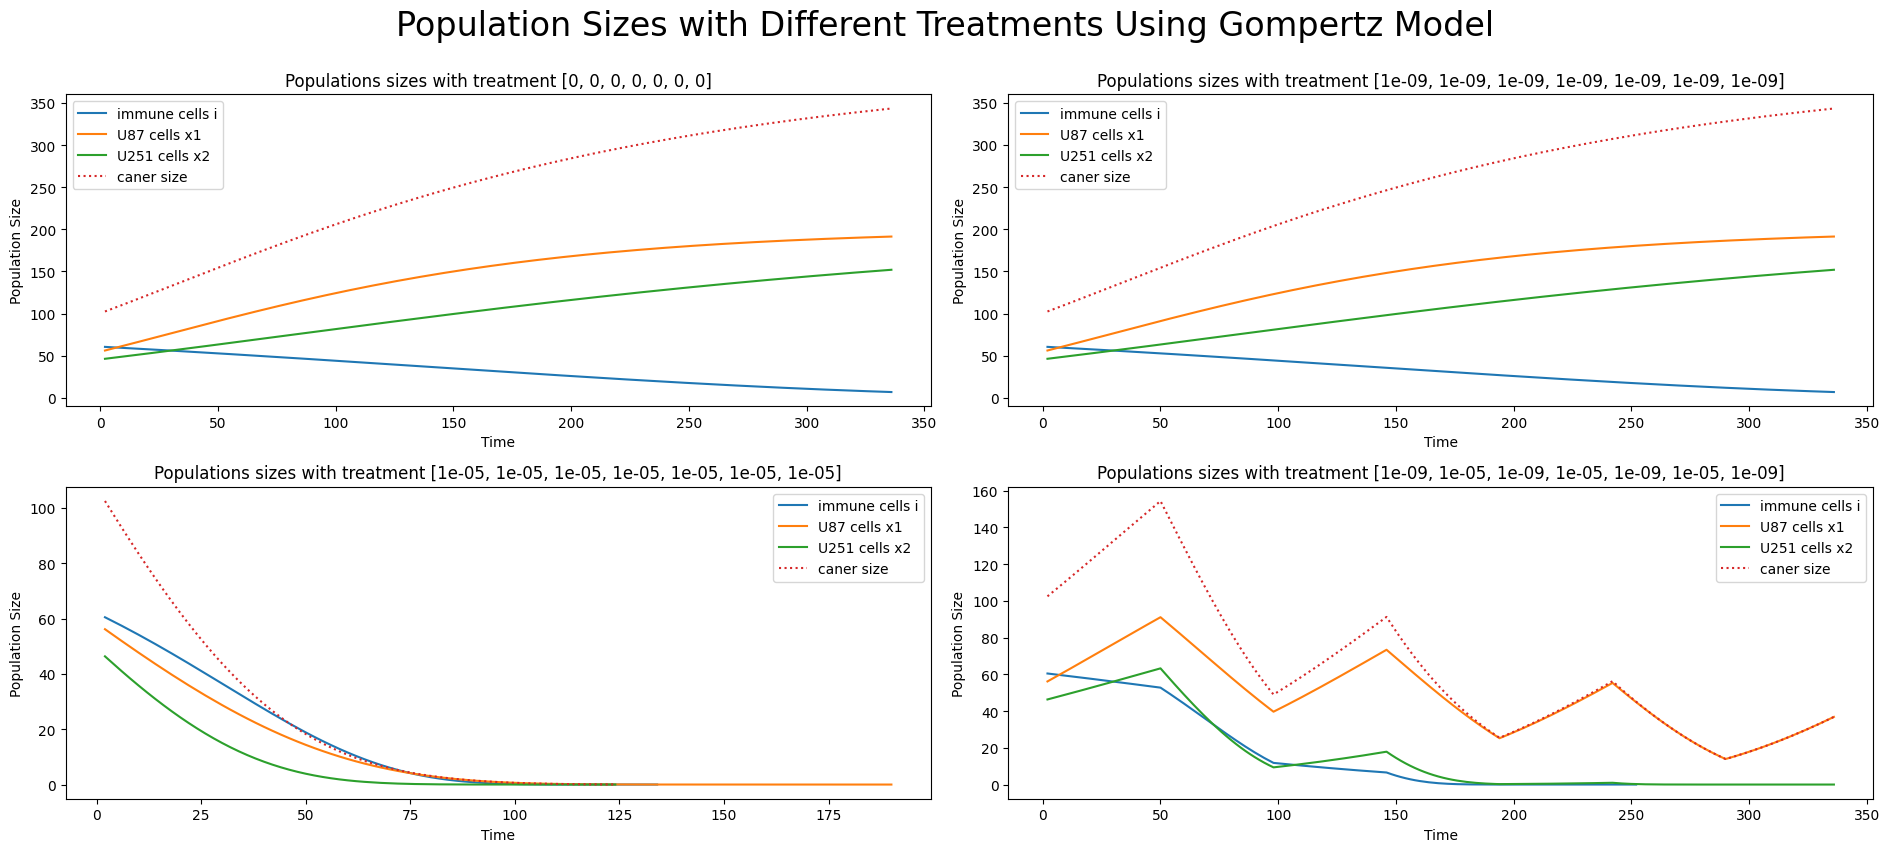

In [74]:
param = [r1, r2, r3, c1, c2, c3, k1, k2, k3]
i, x1, x2 = np.array(gompertz(x0,treatment_full, param, show_plot=True))

### Plot the Change of Rate of i, x1, x2 (didt, dx1dt, dx2dt).

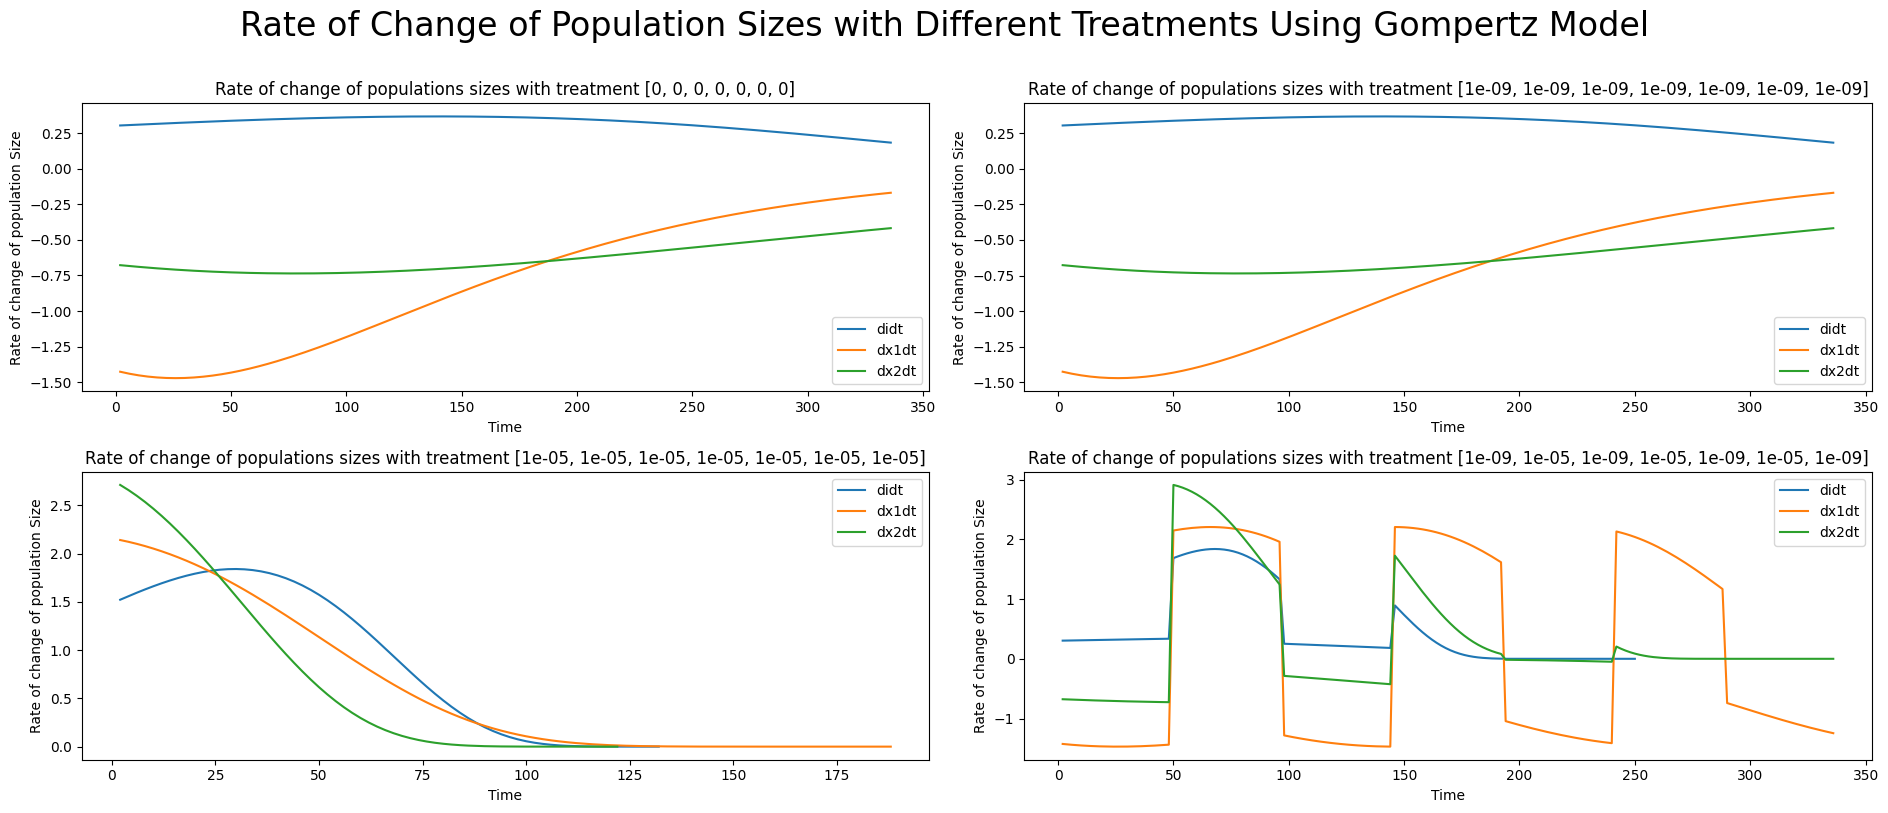

In [75]:
def ODEs(V, t, treatment_interpolator, r1, r2, r3, c1, c2, c3, k1, k2, k3):
    ''' 
    function that returns the rate of change of the populations sizes
    V: list of population sizes
    t: time
    treatment_interpolator: function that returns the treatment at time t
    r1, r2, r3: growth rates
    c1, c2, c3: death rates
    k1, k2, k3: carrying capacities
    returns: list of the rate of change of the populations sizes
    '''
    i, x1, x2 = V 
    current_treatment = treatment_interpolator(t) 
    didt = i * (r1 - c1 - c1 * 10**5 * current_treatment) * np.log(i/k1)
    dx1dt = x1 * (r2 - c2 - c2 * 10**5 * current_treatment) * np.log(x1/k2)
    dx2dt = x2 * (r3 - c3 - c3 * 10**5 * current_treatment) *np.log(x2/k3)
    return [didt, dx1dt, dx2dt]
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9.5 * num_cols, 8))
for I in range(len(Treatment)):
    V = [i[I], x1[I], x2[I]]
    treatment_interpolator = interpolate.interp1d(t, treatment_full[I], fill_value="extrapolate")
    didt, dx1dt, dx2dt = ODEs(V, t, treatment_interpolator, r1, r2, r3, c1, c2, c3, k1, k2, k3)
    row = I // num_cols
    col = I % num_cols    
    ax = axes[row, col] 
    for k, label in zip([didt, dx1dt, dx2dt], ['didt', 'dx1dt', 'dx2dt']):
        ax.plot(t, k, '-', label=label)
    ax.set_title(f'Rate of change of populations sizes with treatment {Treatment[I]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Rate of change of population Size')
    ax.legend() 
fig.suptitle("Rate of Change of Population Sizes with Different Treatments Using Gompertz Model", fontsize=24, y=1.01)
plt.tight_layout() 
plt.show()

---
## Bertalanffy Model
The bertalanffy model is geven by:
$\dot{N}_i=N_i^\alpha r_i- N_i (c_i - c_i q(t))$ 
where:
* $N_i$: population density
* $r_i$: growth rate
* $q(t)$: amoutnt of treatment at time t 
* $c_i$: treatment parameters
* $\alpha$: positeve number

In [76]:
def bertalanffy(x0, treatment, params, show_plot:bool = True ):
    """ 
    This function is to simulate the population size of immune cells and cancer cells with different treatments using Bertalanffy model.
    Input:
        x0: initial population size of immune cells and cancer cells
        treatment: a list of treatment, each treatment is a list of concentration of drug
        params: a list of parameters
        show_plot: whether to show the plot of simulation
    Output:
        i1p: a list of population size of immune cells with different treatments
        x1p: a list of population size of U87 cells with different treatments
        x2p: a list of population size of U251 cells with different treatments
    """
    r1, r2, r3, c1, c2, c3, a = params 
    i1p, x1p, x2p = [], [], []
    for i in treatment:
        i_curr, x1_curr, x2_curr = x0 
        i11p, x11p, x22p = [], [], []
        for k in range(len(i)):
            di11 = i_curr**a * r1 - i_curr * (c1 + c1 * 10**5 * i[k])
            dx11 = x1_curr**a * r2 - x1_curr * (c2 + c2 * 10**5 * i[k])
            dx22 = x2_curr**a * r3 - x2_curr * (c3 + c3 * 10**5 * i[k])
            i11p.append(i_curr), x11p.append(x1_curr), x22p.append(x2_curr)
            i_curr += di11
            x1_curr += dx11
            x2_curr += dx22
        i1p.append(i11p), x1p.append(x11p), x2p.append(x22p) 
    if show_plot:
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(9.5 * num_cols, 8))
        for j in range(num_plots):
            row = j // num_cols
            col = j % num_cols
            ax = axes[row, col] 
            for k, label in zip([i1p, x1p, x2p], ['immune cells i', 'U87 cells x1', 'U251 cells x2']):
                ax.plot(t, k[j], '-', label=label)
            ax.plot(t, np.array(x1p[j]) + np.array(x2p[j]), ':', label=f'caner size')
            ax.set_xlabel('Time')
            ax.set_ylabel('Population Size')
            ax.set_title(f'Populations sizes with treatment {Treatment[j]}')
            ax.legend()
            plt.tight_layout()
        fig.suptitle("Population Sizes with Different Treatments Using Bertalanffy Model", fontsize=24, y=1.06)
        plt.show() 
    return i1p, x1p, x2p

### Example: Generate specific data to fit our model to

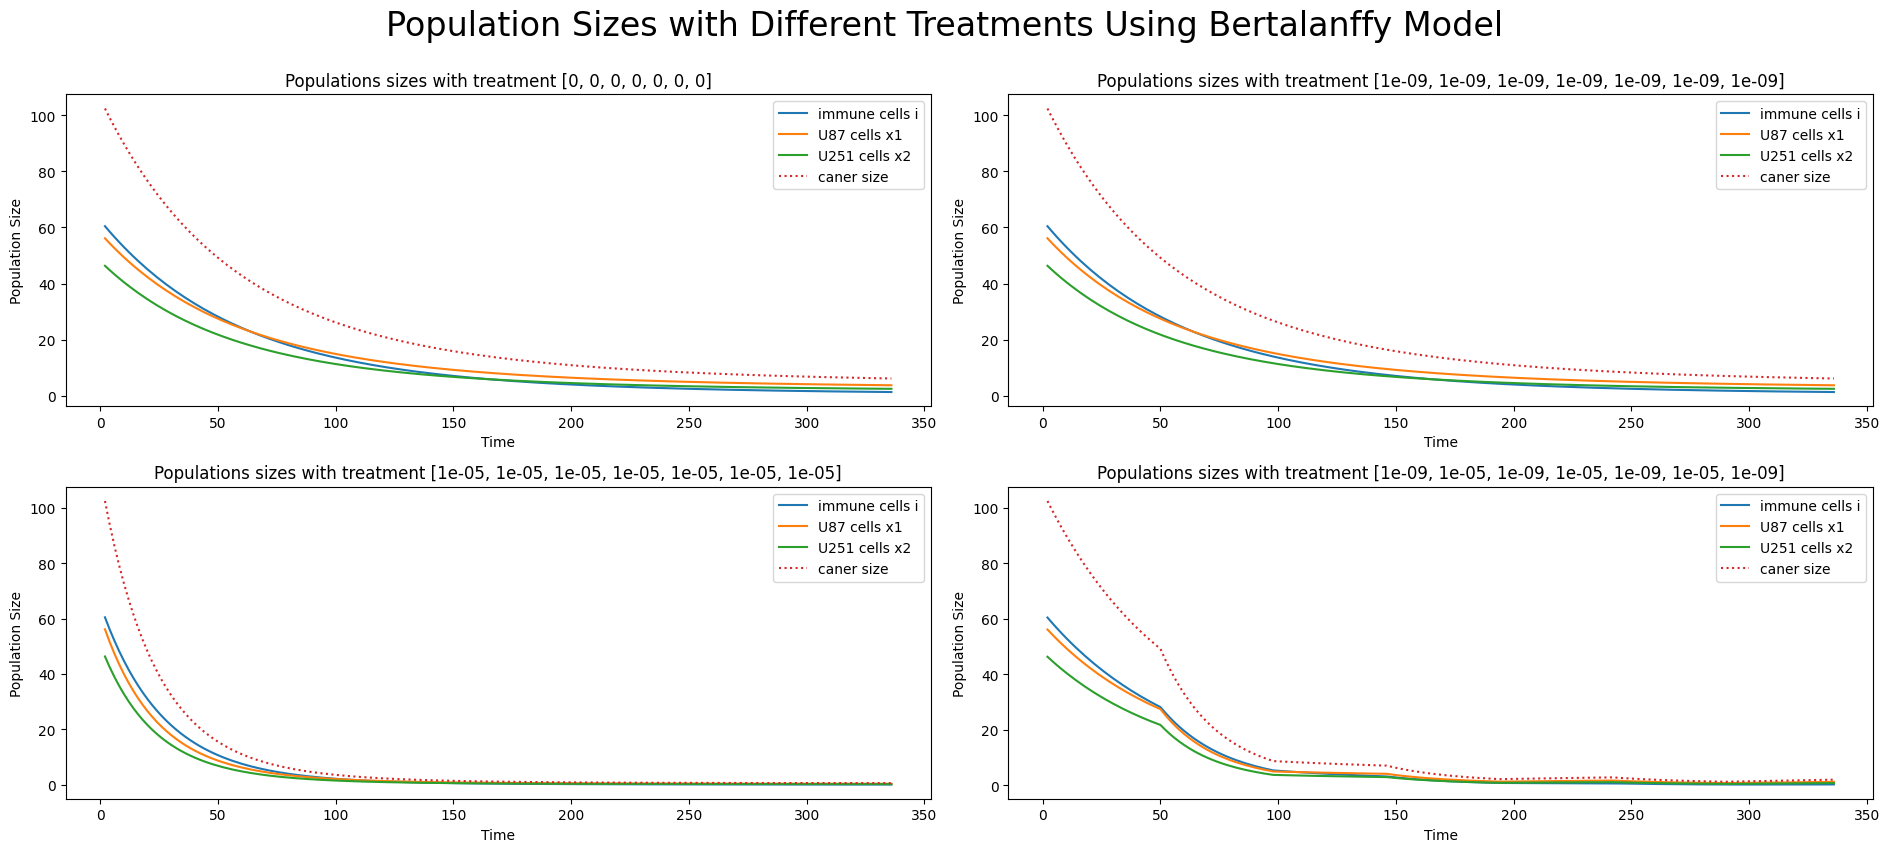

In [77]:
param = [r1, r2, r3, c1, c2, c3, a]
i, x1, x2 = np.array(bertalanffy(x0,treatment_full, param, show_plot=True))

### Plot the Change of Rate of i, x1, x2 (didt, dx1dt, dx2dt).

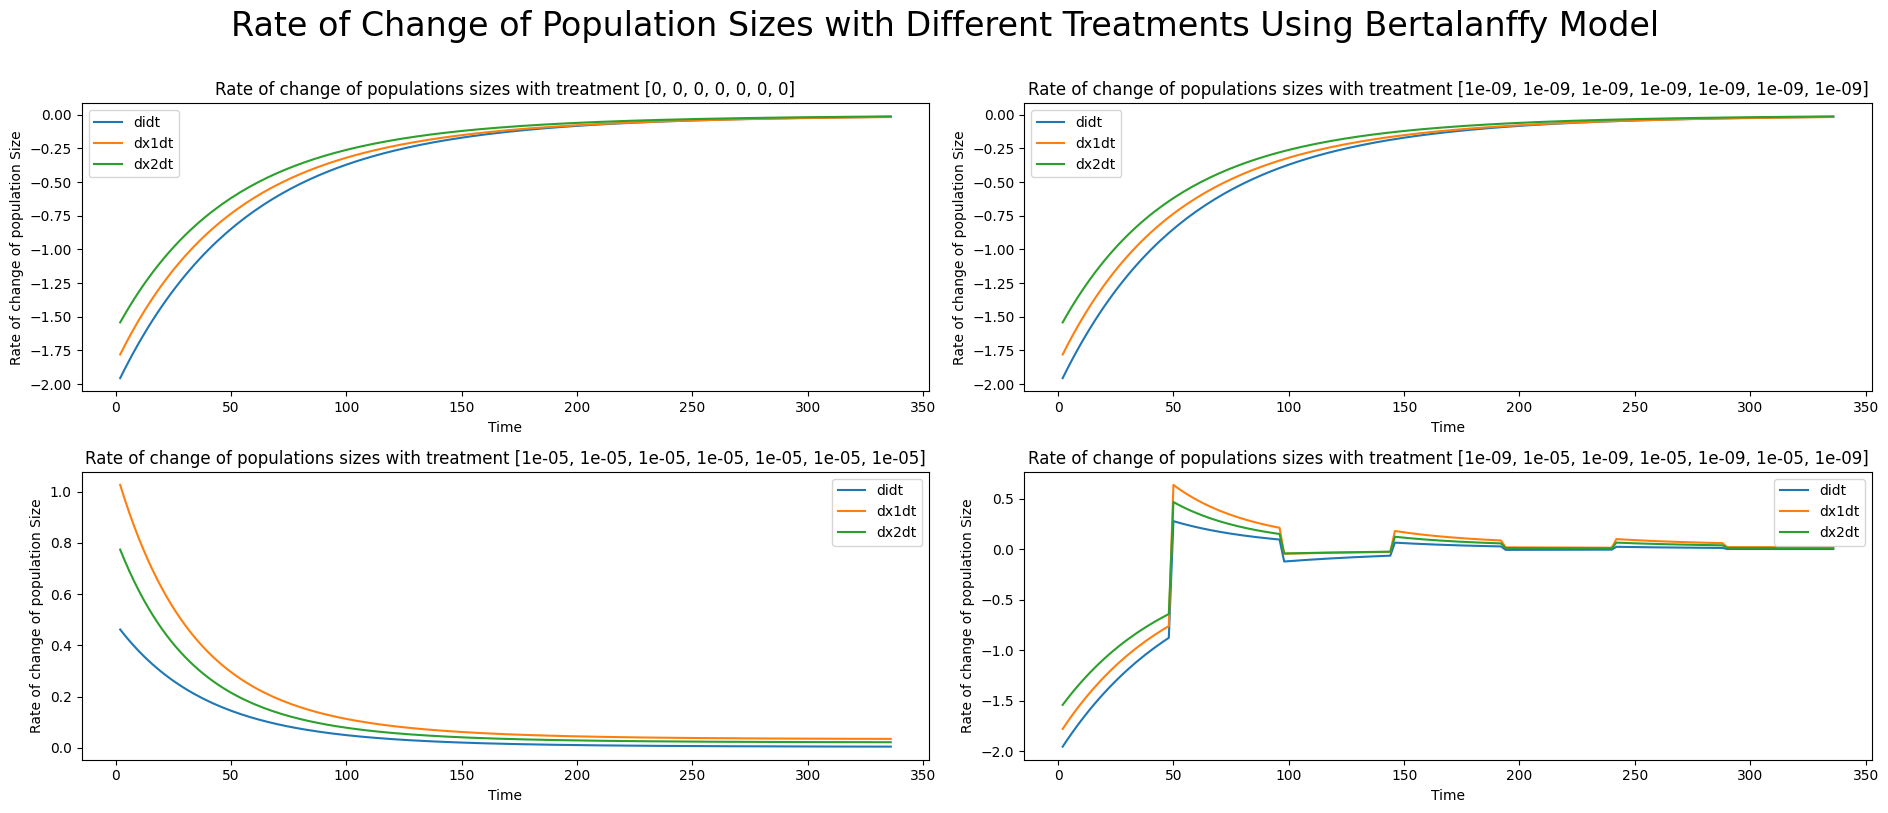

In [78]:
def ODEs(V, t, treatment_interpolator, r1, r2, r3, c1, c2, c3, a):
    '''  
    function that returns the rate of change of the populations sizes   
    V: vector of population sizes
    t: time
    treatment_interpolator: function that returns the treatment at a given time
    r1, r2, r3: growth rates
    c1, c2, c3: carrying capacities
    a: positive constant
    '''
    i, x1, x2 = V 
    current_treatment = treatment_interpolator(t) 
    didt = i**a * r1 - (c1 - c1 * 10**5 * current_treatment) * i
    dx1dt = x1**a * r2 - (c2 - c2 * 10**5 * current_treatment) * x1
    dx2dt = x2**a * r3 - (c3 - c3 * 10**5 * current_treatment) * x2
    return [didt, dx1dt, dx2dt]
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9.5 * num_cols, 8))
for I in range(len(Treatment)):
    V = [i[I], x1[I], x2[I]]
    treatment_interpolator = interpolate.interp1d(t, treatment_full[I], fill_value="extrapolate")
    didt, dx1dt, dx2dt = ODEs(V, t, treatment_interpolator,r1, r2, r3, c1, c2, c3, a )
    row = I // num_cols
    col = I % num_cols    
    ax = axes[row, col]  
    for k, label in zip([didt, dx1dt, dx2dt], ['didt', 'dx1dt', 'dx2dt']):
        ax.plot(t, k, '-', label=label)
    ax.set_title(f'Rate of change of populations sizes with treatment {Treatment[I]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Rate of change of population Size')
    ax.legend()
fig.suptitle("Rate of Change of Population Sizes with Different Treatments Using Bertalanffy Model", fontsize=24, y=1.01)
plt.tight_layout() 
plt.show()